### Problem Statement 3: scaling features and feature engineering
**Business Problem:**  
"Create an optimized prediction model for Yearly Amount Spent by engineering new features from customer behavior patterns and properly scaling all inputs. Test hypothesis: 'Power users (high app usage + long membership) spend disproportionately more.'"

"Create new meaningful features and properly scale data to improve predictions. Test if 'power users' spend more."

### Step 1: Understanding Why Scaling Matters

In [10]:
# Why scale?
# Features have different units/ranges:
# - Session Length: ~29-36 (minutes)
# - Time on App: ~8-15 (minutes)
# - Membership: ~0-7 (years)
# 
# Without scaling, features with larger numbers dominate

# load data from a CSV file and print the first 5 rows in well formatted way comma separated values
import pandas as pd
df = pd.read_csv('../linear_regression_problems/data/Ecommerce_Customers.csv')

#print columns

print(df.columns.tolist())

# Select multiple features
feature_columns_all = df.columns.tolist()
print("Feature Columns:", feature_columns_all)

feature_columns = ['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']


# Check current scales
print("Current Feature Ranges:")
for col in feature_columns:
    print(f"{col:25s}: {df[col].min():.2f} to {df[col].max():.2f}")

['Email', 'Address', 'Avatar', 'Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership', 'Yearly Amount Spent']
Feature Columns: ['Email', 'Address', 'Avatar', 'Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership', 'Yearly Amount Spent']
Current Feature Ranges:
Avg. Session Length      : 29.53 to 36.14
Time on App              : 8.51 to 15.13
Time on Website          : 33.91 to 40.01
Length of Membership     : 0.27 to 6.92


<br>
<br>

### Step 2: Create Engineered Features

In [11]:
# Feature Engineering = Creating new features from existing ones
# Based on domain knowledge and hypotheses

# Create a copy to work with
df_engineered = df.copy()

# New Feature 1: Total Digital Engagement
df_engineered['Total Digital Time'] = df_engineered['Time on App'] + df_engineered['Time on Website']

# New Feature 2: Engagement Intensity
df_engineered['Engagement Intensity'] = (
    df_engineered['Avg. Session Length'] / 100  # Divide by 100 to keep reasonable scale
)

# New Feature 3: App Preference Ratio
df_engineered['App Preference'] = (
    df_engineered['Time on App'] / 
    (df_engineered['Time on App'] + df_engineered['Time on Website'] + 1)  # +1 to avoid division by zero
)

# New Feature 4: Member Value (spending per year of membership)
df_engineered['Member Value'] = (
    df_engineered['Yearly Amount Spent'] / 
    (df_engineered['Length of Membership'] + 0.1)  # +0.1 to avoid division by zero
)

# New Feature 5: Power User Flag (categorical → numerical)
median_app_time = df_engineered['Time on App'].median()
median_membership = df_engineered['Length of Membership'].median()
df_engineered['Is Power User'] = (
    (df_engineered['Time on App'] > median_app_time) & 
    (df_engineered['Length of Membership'] > median_membership)
).astype(int)  # Convert True/False to 1/0

print("New features created:")
new_features = ['Total Digital Time', 'Engagement Intensity', 'App Preference', 'Is Power User']
for feat in new_features:
    print(f"  - {feat}")

New features created:
  - Total Digital Time
  - Engagement Intensity
  - App Preference
  - Is Power User


### Step 3: Visualize New Features

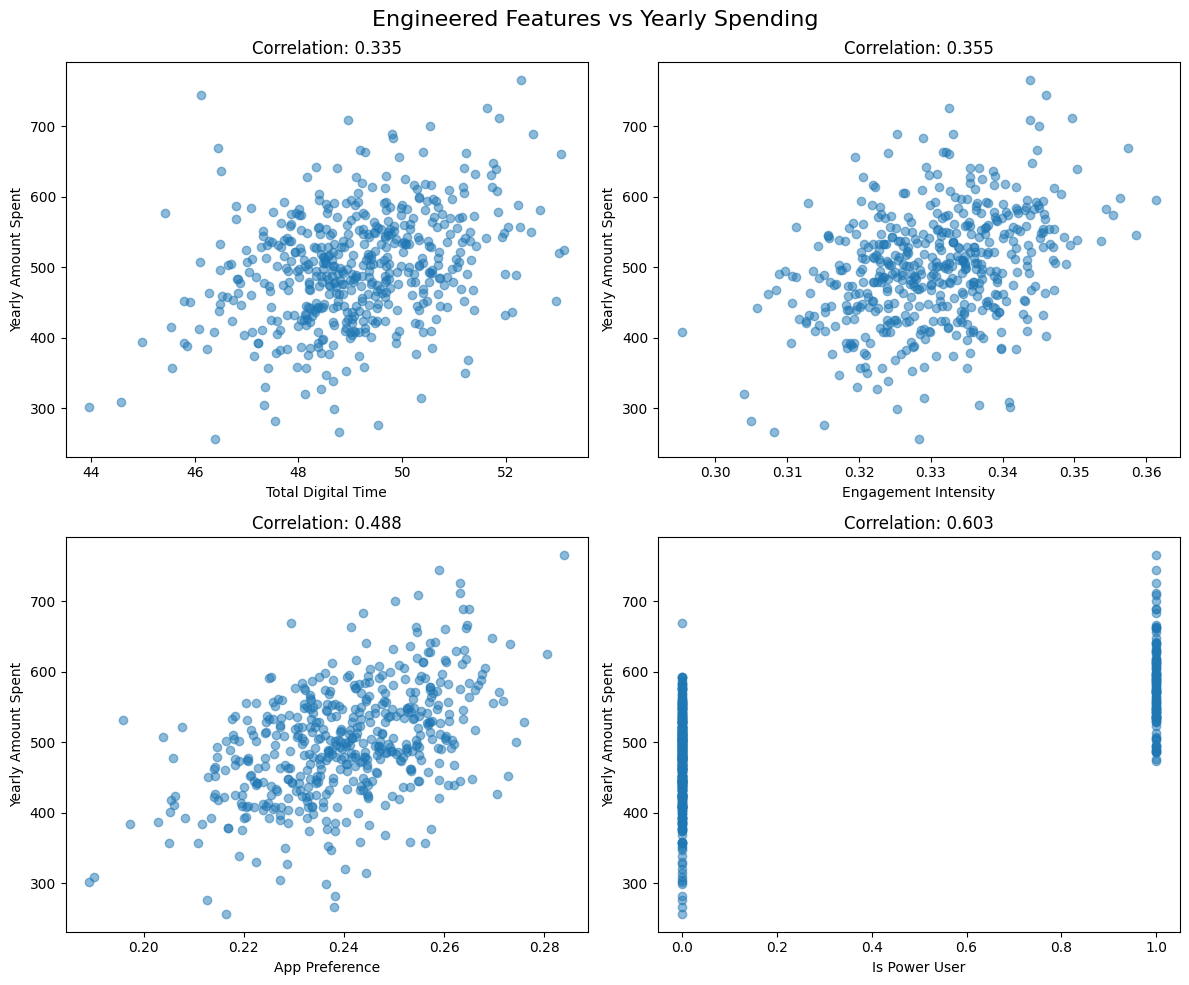

In [14]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Check if new features have predictive power
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Engineered Features vs Yearly Spending', fontsize=16)

for idx, feat in enumerate(new_features):
    ax = axes[idx//2, idx%2]
    ax.scatter(df_engineered[feat], df_engineered['Yearly Amount Spent'], alpha=0.5)
    ax.set_xlabel(feat)
    ax.set_ylabel('Yearly Amount Spent')
    
    # Add correlation value
    corr = df_engineered[feat].corr(df_engineered['Yearly Amount Spent'])
    ax.set_title(f'Correlation: {corr:.3f}')

plt.tight_layout()
plt.show()



### Step 4: Prepare Features with Scaling

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select all features (original + engineered)
all_features = feature_columns + new_features
X_all = df_engineered[all_features]
y = df_engineered['Yearly Amount Spent']

# Split first (IMPORTANT: Scale after splitting to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42
)

# Create scaler
# StandardScaler: Makes mean=0, std=1 (good for normal distributions)
# MinMaxScaler: Scales to 0-1 range (good for bounded data)
scaler = StandardScaler()

# Fit scaler on training data, then transform both sets
# Why fit only on train? Test data should be "unseen"
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform
X_test_scaled = scaler.transform(X_test)        # Only transform

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=all_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=all_features, index=X_test.index)

print("Features after scaling (first 3 samples):")
print(X_train_scaled.head(3))

Features after scaling (first 3 samples):
     Avg. Session Length  Time on App  Time on Website  Length of Membership  \
249             0.728756    -0.140376        -0.173216              0.065197   
433             1.233670    -0.235492        -0.700765             -1.413095   
19             -0.449465     1.935961         0.166982              0.483620   

     Total Digital Time  Engagement Intensity  App Preference  Is Power User  
249           -0.213653              0.728756       -0.068267      -0.604308  
433           -0.640173              1.233670        0.005115      -0.604308  
19             1.420326             -0.449465        1.766260       1.654786  


### Step 5: Compare Models

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Model 1: Original features without scaling
model_original = LinearRegression()
model_original.fit(X_train[feature_columns], y_train)
y_pred_original = model_original.predict(X_test[feature_columns])
r2_original = r2_score(y_test, y_pred_original)

# Model 2: Original features with scaling
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled[feature_columns], y_train)
y_pred_scaled = model_scaled.predict(X_test_scaled[feature_columns])
r2_scaled = r2_score(y_test, y_pred_scaled)

# Model 3: All features (original + engineered) with scaling
model_engineered = LinearRegression()
model_engineered.fit(X_train_scaled, y_train)
y_pred_engineered = model_engineered.predict(X_test_scaled)
r2_engineered = r2_score(y_test, y_pred_engineered)

# Compare all models
comparison_df = pd.DataFrame({
    'Model': ['Original', 'Original + Scaling', 'Engineered + Scaling'],
    'R² Score': [r2_original, r2_scaled, r2_engineered],
    'MAE': [
        mean_absolute_error(y_test, y_pred_original),
        mean_absolute_error(y_test, y_pred_scaled),
        mean_absolute_error(y_test, y_pred_engineered)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_original)),
        np.sqrt(mean_squared_error(y_test, y_pred_scaled)),
        np.sqrt(mean_squared_error(y_test, y_pred_engineered))
    ]
})

print("\nModel Comparison:")
print(comparison_df)

# Note: For linear regression, scaling doesn't change R² 
# But it's crucial for regularization and gradient-based methods


Model Comparison:
                  Model  R² Score       MAE       RMSE
0              Original  0.977813  8.558442  10.481591
1    Original + Scaling  0.977813  8.558442  10.481591
2  Engineered + Scaling  0.978229  8.441975  10.382841


### Step 6: Interpret Scaled Coefficients

In [21]:
# With scaled features, coefficients show relative importance
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': model_engineered.coef_,
    'Abs_Coefficient': np.abs(model_engineered.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

# Create importance plot
fig = px.bar(
    coef_df.head(10),
    x='Coefficient',
    y='Feature',
    orientation='h',
    title='Feature Importance with Engineered Features (Scaled)',
    color='Coefficient',
    color_continuous_scale='RdBu_r'
)
fig.show()

print("\nTop 5 Most Important Features:")
print(coef_df.head(5)[['Feature', 'Coefficient']])


Top 5 Most Important Features:
                Feature  Coefficient
3  Length of Membership    63.741259
1           Time on App    32.041409
4    Total Digital Time    14.405952
5  Engagement Intensity    12.617480
0   Avg. Session Length    12.617480


### Step 7: Test Power User Hypothesis

In [22]:
# Check if power users really spend more
power_users = df_engineered[df_engineered['Is Power User'] == 1]
regular_users = df_engineered[df_engineered['Is Power User'] == 0]

print("Power User Analysis:")
print(f"Power Users: {len(power_users)} customers")
print(f"Regular Users: {len(regular_users)} customers")
print(f"\nAverage Yearly Spending:")
print(f"Power Users: ${power_users['Yearly Amount Spent'].mean():.2f}")
print(f"Regular Users: ${regular_users['Yearly Amount Spent'].mean():.2f}")
print(f"Difference: ${power_users['Yearly Amount Spent'].mean() - regular_users['Yearly Amount Spent'].mean():.2f}")

# Visualize distribution
fig = go.Figure()
fig.add_trace(go.Box(y=power_users['Yearly Amount Spent'], name='Power Users'))
fig.add_trace(go.Box(y=regular_users['Yearly Amount Spent'], name='Regular Users'))
fig.update_layout(
    title='Spending Distribution: Power Users vs Regular Users',
    yaxis_title='Yearly Amount Spent ($)'
)
fig.show()

Power User Analysis:
Power Users: 126 customers
Regular Users: 374 customers

Average Yearly Spending:
Power Users: $581.59
Regular Users: $471.59
Difference: $110.00
